In [2]:
from lifelines.plotting import plot_lifetimes
import numpy as np
from numpy.random import uniform, exponential

$$f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta})$$

In [85]:
n = 25
current_time = 12
bound_plot = 30 + 1

np.random.seed(41)
actual_lifetimes = np.array([exponential(12) if uniform() < 0.5 else exponential(2) for i in range(n)])
actual_lifetimes

array([ 0.56630464,  0.08888518, 11.11202347, 13.2500986 ,  1.08525217,
        3.99271621,  4.57706611,  0.8646624 ,  0.75572985,  1.01570276,
        2.60726577,  6.00868609,  6.99354515, 10.51348136, 16.22744123,
        1.61917399, 12.35779027,  0.65979244,  4.12086372,  0.49202537,
       15.34007428,  7.40945009,  3.98651787,  4.14885603,  3.94324599])

#### Censure

In [86]:
observed_lifetimes = np.minimum(actual_lifetimes, current_time)
death_observed = actual_lifetimes < current_time

#### Plot

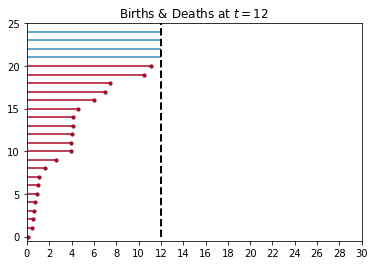

In [87]:
ax = plot_lifetimes(durations=observed_lifetimes, event_observed=death_observed)

ax.set_xlim(0, 25)
ax.vlines(current_time, 0, bound_plot, lw=2, linestyles='--')

ax.set_label('Time')
ax.set_title(f'Births & Deaths at $t={current_time}$')
ax.set_xticks(range(0, bound_plot, 2))
ax.plot();

#### Survival function properties:

1. $S(t) \in [0, 1] $
2. $F_{T}(t) = 1 - S(t)$
3. $S(t)$ is non-increasing

#### Hazard function:

$$
h(t) = \lim_{\delta t \to 0}\frac{{P(t \le T \le t+\delta t | T>t)}}{\delta t}
$$


### Kaplan-Meier Estimate

$$
\hat{S}(t) = \prod_{t_i<t}{\frac{n_i-d_i}{n_i}}
$$


* $d_i$ - number of death events at time $t$
* $n_i$ - number of subjects at risk of death prior to time $t$

In [90]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

df = load_dd()
df.sample(3)

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
1290,Portugal,235,235.0,Southern Europe,Europe,Marcelo Caetano,Marcelo Caetano.Portugal.1968.1973.Civilian Dict,Non-democracy,Civilian Dict,1968,6,1
1082,Myanmar,775,775.0,South-Eastern Asia,Asia,U Nu,U Nu.Myanmar.1960.1961.Parliamentary Dem,Democracy,Parliamentary Dem,1960,2,1
1134,New Zealand,920,920.0,Australia and New Zealand,Oceania,Norman Kirk,Norman Kirk.New Zealand.1972.1973.Parliamentar...,Democracy,Parliamentary Dem,1972,2,0


In [91]:
timeline = df['duration']
event = df['observed']

kmf.fit(durations=timeline, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

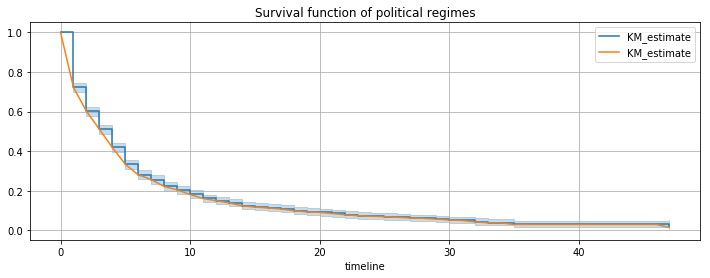

In [109]:
ax = plt.subplot(111)

kmf.plot(ax=ax)
kmf.survival_function_.plot(figsize=(12,4), grid=True, ax=ax)

ax.set_title('Survival function of political regimes')
ax.plot();


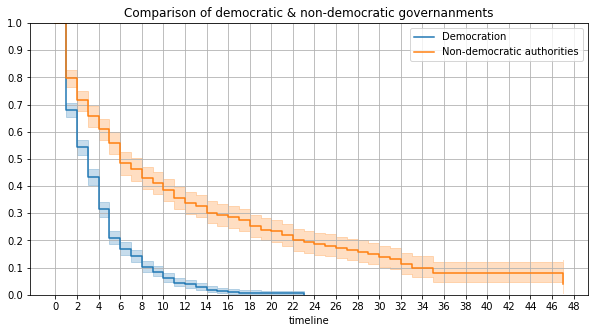

In [141]:
ax = plt.subplot(111)

ax.set_title('Comparison of democratic & non-democratic governanments')
democracy = (df['democracy'] == 'Democracy')
kmf.fit(durations=timeline[democracy], event_observed=event[democracy], label='Democration')
kmf.plot(ax=ax, figsize=(10, 5), grid=True)
kmf.fit(durations=timeline[~democracy], event_observed=event[~democracy], label='Non-democratic authorities')
kmf.plot(ax=ax, grid=True)
plt.ylim(0,1)

plt.xticks(np.arange(0, 51, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.plot();


In [167]:
df[(df['democracy'] == 'Democracy') & (df['duration'] > 16)]

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
64,Australia,900,900.0,Australia and New Zealand,Oceania,Robert Menzies,Robert Menzies.Australia.1949.1965.Parliamenta...,Democracy,Parliamentary Dem,1949,17,1
89,Bahamas,31,31.0,Caribbean,Americas,Lynden Pindling,Lynden Pindling.Bahamas.1973.1991.Parliamentar...,Democracy,Parliamentary Dem,1973,19,1
732,India,750,750.0,Southern Asia,Asia,Jawaharlal Nehru,Jawaharlal Nehru.India.1947.1963.Parliamentary...,Democracy,Parliamentary Dem,1947,17,0
1501,Sweden,380,380.0,Northern Europe,Europe,Tage Erlander,Tage Erlander.Sweden.1946.1968.Parliamentary Dem,Democracy,Parliamentary Dem,1946,23,1
1628,Trinidad and Tobago,52,52.0,Caribbean,Americas,Eric Williams,Eric Williams.Trinidad and Tobago.1962.1980.Pa...,Democracy,Parliamentary Dem,1962,19,0


In [168]:
from lifelines.statistics import logrank_test


In [170]:
results = logrank_test(
    durations_A=timeline[democracy],
    durations_B=timeline[~democracy],
    event_observed_A=event[democracy],
    event_observed_B=event[~democracy],
    alpha=.8
    )
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.8

---
test_statistic      p  -log2(p)
        260.47 <0.005    192.23


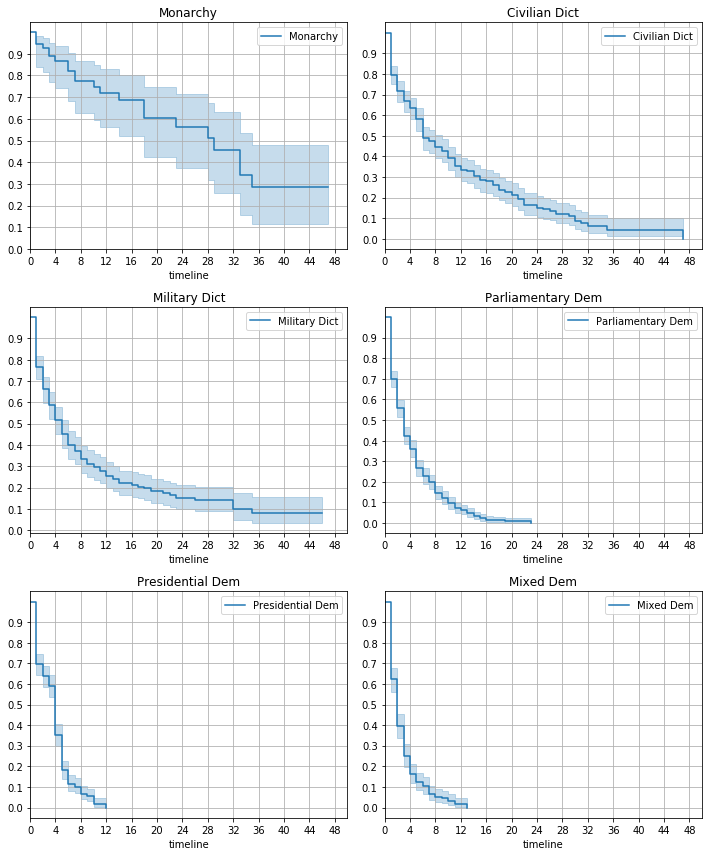

In [195]:
regimes = df['regime'].unique()

for i, regime in enumerate(regimes):
    ax = plt.subplot(3, 2, i+1)
    
    ix = df['regime'] == regime
    kmf.fit(durations=timeline[ix], event_observed=event[ix], label=regime)
    kmf.plot(ax=ax, grid=True, legend=True, figsize=(10, 12))
    
    plt.xticks(np.arange(0, 51, 4))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.title(regime)
    plt.xlim(0, 50)
    
plt.tight_layout()

### Hang around with datetimes

In [199]:
from lifelines.utils import datetimes_to_durations

In [200]:
start_date = ['2013-10-10 0:00:00', '2013-10-09', '06/03/2012']
end_date = ['2013-10-13', '2013-10-10', None]
T, E = datetimes_to_durations(start_date, end_date, fill_date='2013-10-15')
print('T (durations): ', T)
print('E (event_observed): ', E)

T (durations):  [  3.   1. 499.]
E (event_observed):  [ True  True False]
